# Federated Machine Learning with MNIST

This notebook is a demonstration of _federated learning_, a type of machine learning in which a machine learning task is addressed using multiple devices. Let's first talk about what we're going to see here.

## The Task: Digit Recognition

For this demonstration, our task is to determine which number is written in an image of a handwritten digit like this one: 

![Handwritten digit "6"](images/example-6.png)

To carry out this task we need a machine learning model to "look" at an image and classify it into a number, and image data to train the model. We're going to use a simple convolutional neural network model. For the training images, we're using the well-known MNIST digits dataset.

## The Approach: Federation

The federated approach uses several _worker_ devices to train their own local models with independent data. That is, the workers each train their local model with a unique set of data.

The workers train their models for a bit, then each worker sends its local model back to a _manager_. The manager combines the local models from all of the workers into a master model, then sends the master model back to the workers. This process is called a _round_. Then another round begins: the workers train their copy of the master model (creating another set of individualized local models), the manager combines these individualized local models into a new master model, and pushes the new master model down to the workers. This cycle of rounds repeats as long as is necessary and useful.

## Our Federation Library

The `federated` library we're using here includes a `FederatedManager` class and a `FederatedWorker` class. A `FederatedManager` contains a master prediction model and creates several independent `FederatedWorker` instances. Each `FederatedWorker` has its own local model and a distinct subset of the MNIST data.

In each `round` of federated learning, each `FederatedWorker` trains its local model using only the data that that worker recieves, and then sends its trained local model to the `FederatedManager`. The `FederatedManager` combines the models into an updated master model and pushes that new master model down to each `FederatedWorker`.

We're going to see how federation works and test out some corner cases here. Let's get started with the code.

## The Basics

We need to load up the common elements to be used in the traditional and federated machine learning approaches. But we do a little housekeeping first to track performance of the code.

In [3]:
import time
import datetime

run_data = {} # used for code profiling

run_data['Date'] = datetime.datetime.today().strftime('%Y-%m-%d %H:%M:%S')
run_data['Global Start Time'] = time.time()

### The Model

Now we define the model. We're using a simple multilayer perceptron in the `torch` framework.

In [4]:
# Define the model

import torch.nn as nn

class MLPNet(nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 500)
        self.fc2 = nn.Linear(500, 256)
        self.fc3 = nn.Linear(256, 10)
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def name(self):
        return "MLP"

# # Optional model for fun

# import torch.nn.functional as F

# class LeNet(nn.Module):
#     def __init__(self):
#         super(LeNet, self).__init__()
#         self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
#         self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
#         self.conv2_drop = nn.Dropout2d()
#         self.fc1 = nn.Linear(320, 50)
#         self.fc2 = nn.Linear(50, 10)

#     def forward(self, x):
#         x = F.relu(F.max_pool2d(self.conv1(x), 2))
#         x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
#         x = x.view(-1, 320)
#         x = F.relu(self.fc1(x))
#         x = F.dropout(x, training=self.training)
#         x = self.fc2(x)
#         return F.log_softmax(x, dim=0) # value 0 was chosen arbitrarily to quiet a warning. Penny'll start a fire.

#     def name(self):
#         return 'LeNet'

### The Data - Standard MNIST Datasets
Here we get plain vanilla MNIST datasets, balanced the way the gods intended, and we make datatloaders from them. Nothing exciting to see here. This is our baseline. If you don't already have the MNIST data on your machine, the calls to `torchvision.datasets.MNIST(... dowload=True ...)` will download it for you.

In [5]:
# load the data

import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms

# create standard datasets using all of the MNIST data

data_path = './MNIST-data/raw'
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

train_dset = dsets.MNIST(root=data_path, download=True, train=True, transform=trans)
test_dset = dsets.MNIST(root=data_path, download=True, train=False, transform=trans)

In [6]:
# create dataloaders

from torch.utils.data import DataLoader

run_data['Batch Size'] = batch_size = 128

# create standard dataloaders using all of the MNIST data - this is for baseline purposes
train_dloader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
test_dloader = DataLoader(test_dset, batch_size=batch_size, shuffle=False)

Let's check out the goods. We expect than the out-of-the-box MNIST dataset will have roughly equal numbers of samples for each numeral.

In [7]:
from collections import Counter
import numpy as np
#import statistics

train_counts = Counter(int(y) for y in train_dset.targets).most_common()
print("Train counts: \n", train_counts)
print("Train mean: %.2f" % np.mean(list(zip(*train_counts))[1]))
print("Train stdev: %.2f" % np.std(list(zip(*train_counts))[1]))
#print('stat.stdev', statistics.stdev(list(zip(*train_counts))[1])) # WTF MLW?
#print("Train var: %.2f" % np.var(list(zip(*train_counts))[1])) # WTF MLW?
print("Train CV: %.2f" % (float(np.mean(list(zip(*train_counts))[1])) / float(np.std(list(zip(*train_counts))[1]))))

print()

test_counts = Counter(int(y) for y in test_dset.targets).most_common()
print("Test counts: \n", test_counts)
print("Test mean: %.2f" % np.mean(list(zip(*test_counts))[1]))
print("Test stdev: %.2f" % np.std(list(zip(*test_counts))[1]))
print("Test CV: %.2f" % (float(np.mean(list(zip(*test_counts))[1])) / float(np.std(list(zip(*test_counts))[1]))))

Train counts: 
 [(1, 6742), (7, 6265), (3, 6131), (2, 5958), (9, 5949), (0, 5923), (6, 5918), (8, 5851), (4, 5842), (5, 5421)]
Train mean: 6000.00
Train stdev: 322.08
Train CV: 18.63

Test counts: 
 [(1, 1135), (2, 1032), (7, 1028), (3, 1010), (9, 1009), (4, 982), (0, 980), (8, 974), (6, 958), (5, 892)]
Test mean: 1000.00
Test stdev: 59.20
Test CV: 16.89


The training data looks reasonably well distributed, and the plots below confirm it.

TODO: Use a better metric of distribution? std?

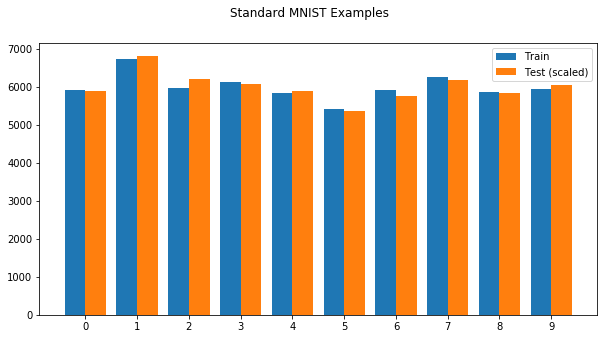

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Standard MNIST Examples')
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.hist([train_dloader.dataset.targets.tolist(), test_dloader.dataset.targets.tolist()*6], 
        label=['Train', 'Test (scaled)'],
        bins=list(range(11)), 
        histtype='bar',
        align='left',
        rwidth=0.8,
       )
ax.legend();

NOTE: DO WE WANT TO JUST TRAIN THE BASELINE MODEL HERE BEFORE STACKING THE DECK?

AND THEN DO WE WANT TO SHOW A MODEL TRAINED ONLY ON ONE SKEWED DATASET?

### Stacking a Deck (Skewing the Data)

We know the baseline data is pretty even across numerals. Now we need a way to "stack the deck" of examples that each worker sees. This method creates a dataset that is randomly sampled from a given dataset with the random sampling biased according to a dictionary of weights for each label.

In [9]:
from torch.utils.data import WeightedRandomSampler

def stacked_dset(dset, label_weights, N):
    """
    dset: dataset
    label_weights = {dog: 0.5, cat: 0.3, ...}
    N: size of stacked dset
    return: stacked WeightedRandomSampler
    """
    weights = []
    for data, label in dset:
        weights.append(label_weights[label])

#     for label in test_dset.targets:
#         weights.append(label_weights[int(label)])
# TODO / MLW : how to speed this up - currently takes about a minute to train ten stacked training sets
    
    return WeightedRandomSampler(weights, N, replacement=False)

And this is where we get the dictionary of weights. For simplicity's sake, we just take a list of labels to be sampled "normally" and the rest are biased against. So, preserving 3s and skewing everything else by a factor of 0.9 shoud get a set of weights that results in a dataset that is slightly heavy on 3s compared to everything else. In an an extreme example, preserving only 3s, with a skew of 0, will produce weights that will yield a dataset of only 3s.

In [10]:
def skewed_weights(num_labels, labels_to_preserve, skew_bias):
    """
        num_labels: number of labels to return (use 10 for MNIST)
        labels_to_preserve: list of labels to preserve wih no skew 
        skew_bias: a float, 0 < bias < 1, to which non-selected labels will be biased down
        return: dictionary of each label and its bias
    """
    weights = {}
    for label in range(num_labels):
        if label in labels_to_preserve:
            weights[label] = 1
        else:
            weights[label] = skew_bias
    
    return weights

### 

Here we do the sampling to create our skewed datasets.

In [61]:
from tqdm import tqdm

# create stacked loaders for the workers

run_data['Skew Bias'] = skew_bias = 0.5
run_data['Examples Per Skewed Loader'] = loader_size = 256
run_data['Number of Workers'] = num_workers = 3

stacking_start_time = time.time()

stacked_data_loaders = []
for label in tqdm(range(num_workers)):
    stacked_sampler = stacked_dset(train_dset, skewed_weights(10, [label%10], skew_bias), loader_size)
    stacked_data_loaders.append(DataLoader(train_dset, batch_size=batch_size, shuffle=False, sampler=stacked_sampler))

run_data['Stacking Time'] = time.time() - stacking_start_time
run_data['Stacking Time per Loader'] = run_data['Stacking Time'] / run_data['Number of Workers']

print('Stacking Time: %.2f' % run_data['Stacking Time'])
print('Stacking Time per Loader: %.2f' % run_data['Stacking Time per Loader'])

100%|██████████| 3/3 [00:26<00:00,  8.85s/it]

Stacking Time: 26.02
Stacking Time per Loader: 8.67


We should see the effect of the skew in a count and histogram of a skewed dataset. Here, we arbitrarily picked the second dataloader.

In [62]:
_, ybatches = list(zip(*stacked_data_loaders[1]))
ys = torch.cat(ybatches)
ys = [int(y) for y in ys]
print (Counter(ys).most_common())

# counts = sorted(Counter(ys).most_common())
# print(counts)
# _, counts = zip(*counts)
# print(list(counts))


[(1, 53), (7, 29), (6, 26), (0, 25), (2, 23), (4, 21), (5, 21), (3, 21), (9, 19), (8, 18)]


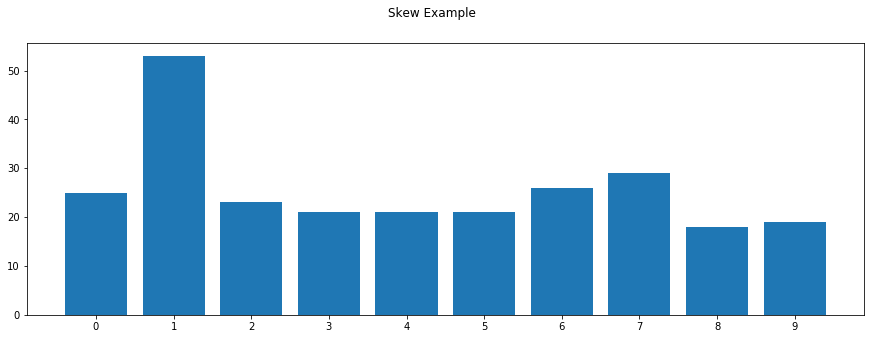

In [63]:
fig, ax = plt.subplots(figsize=(15, 5))
fig.suptitle('Skew Example')
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
H = ax.hist(ys, bins=range(11), histtype='bar', align='left', rwidth=0.8)

In [64]:
hist_counts = []
digit_counts = []
for loader in tqdm(stacked_data_loaders):
    _, ybatches = list(zip(*loader))
    ys = torch.cat(ybatches)
    ys = [int(y) for y in ys]
    hist_counts.append(ys)
    
    digits = sorted(Counter(ys).most_common())
    _, digits = list(zip(*digits))
    digit_counts.append(list(digits))

digit_counts = [list(i) for i in zip(*digit_counts)]

100%|██████████| 3/3 [00:01<00:00,  2.47it/s]


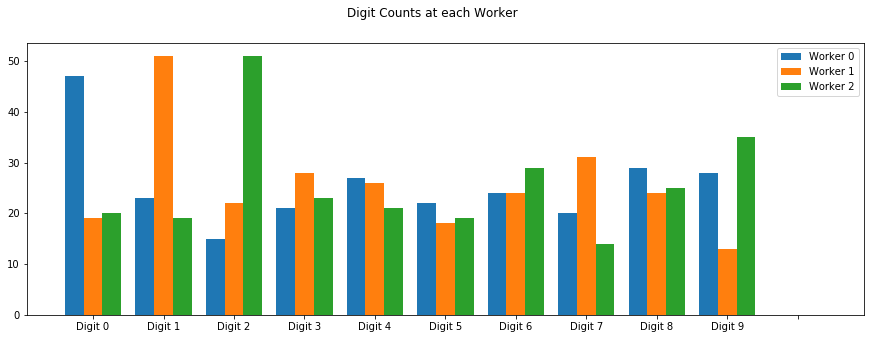

In [65]:
fig, ax = plt.subplots(figsize=(15, 5))
fig.suptitle('Digit Counts at each Worker')
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.set_xticklabels([('Digit ' + str(x-1)) for x in range(11)])
ax.hist(hist_counts, 
        label=[('Worker ' + str(x)) for x in range(num_workers)],
        bins=list(range(12)), 
        histtype='bar',
        align='left',
        rwidth=0.8,
       );
ax.legend();

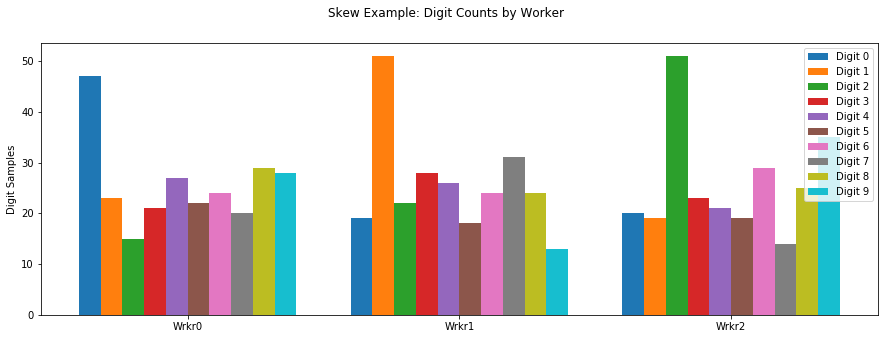

In [66]:
# fig, ax = plt.subplots(figsize=(15, 5))
# fig.suptitle('Skew Examples')
# ax.xaxis.set_major_locator(plt.MultipleLocator(10))
# ax.hist(digit_counts, 
#         label=[('Digit ' + str(x)) for x in range(11)],
#         bins=num_workers + 1, 
#         histtype='bar',
#         align='left',
#         rwidth=0.8,
#        );
# ax.legend();



fig, ax = plt.subplots(figsize=(15, 5))
fig.suptitle('Skew Example: Digit Counts by Worker')

pos = list(range(num_workers))
width = 0.08

for digit in range(10):
    ax.bar([p + (width * digit) for p in pos],
           digit_counts[digit],
           width = width,
           label = 'Digit ' + str(digit),
          )

ax.set_xticks([p + (4.5 * width) for p in pos])
ax.set_xticklabels([('Wrkr' + str(x)) for x in range(num_workers)])
ax.set_ylabel('Digit Samples')
ax.legend(loc = 'upper right');

In [67]:
import federated

run_data['Learning Rate'] = learning_rate = 5e-2
run_data['Epochs per Round'] = num_epochs = 3
run_data['Federated Training Rounds'] = num_rounds = 10

skewed_train_dsets = stacked_data_loaders

manager = federated.FederatedManager(
    skewed_train_dsets,
    MLPNet,
    nn.CrossEntropyLoss(),
    learning_rate,
    test_dset,
    num_epochs
)

In [68]:
print("Training", num_rounds, "round(s) with", manager.n_workers, "worker(s) doing", num_epochs, "epoch(s) per round.\n" )

training_start_time = time.time()

for i in tqdm(range(num_rounds)):
    print("Beginning round", i+1)
    manager.round()
    print("Finished round", i+1, "with global loss: %.5f" % manager.manager_loss_history[-1], "\n")

run_data['Federated Training Time'] = time.time() - training_start_time
#run_data['Manager Loss History'] = manager.manager_loss_history
#run_data['Worker Loss Histories'] = manager.worker_loss_histories
run_data['Final Global Loss'] = manager.manager_loss_history[-1]

print('Federated Training Time: %.2f' % run_data['Federated Training Time'])

  0%|          | 0/10 [00:00<?, ?it/s]

Training 10 round(s) with 3 worker(s) doing 3 epoch(s) per round.

Beginning round 1
	Worker: 7272 	local loss: 2.2788
	Worker: 0784 	local loss: 2.2701
	Worker: 3520 	local loss: 2.2840


 10%|█         | 1/10 [00:04<00:39,  4.38s/it]

Finished round 1 with global loss: 2.28918 

Beginning round 2
	Worker: 7272 	local loss: 2.2728
	Worker: 0784 	local loss: 2.2508
	Worker: 3520 	local loss: 2.2654


 20%|██        | 2/10 [00:08<00:34,  4.34s/it]

Finished round 2 with global loss: 2.27086 

Beginning round 3
	Worker: 7272 	local loss: 2.2294
	Worker: 0784 	local loss: 2.2139
	Worker: 3520 	local loss: 2.2575


 30%|███       | 3/10 [00:13<00:30,  4.38s/it]

Finished round 3 with global loss: 2.25111 

Beginning round 4
	Worker: 7272 	local loss: 2.2124
	Worker: 0784 	local loss: 2.1743
	Worker: 3520 	local loss: 2.2318


 40%|████      | 4/10 [00:17<00:26,  4.34s/it]

Finished round 4 with global loss: 2.22884 

Beginning round 5
	Worker: 7272 	local loss: 2.2011
	Worker: 0784 	local loss: 2.1289
	Worker: 3520 	local loss: 2.1893


 50%|█████     | 5/10 [00:21<00:21,  4.34s/it]

Finished round 5 with global loss: 2.20360 

Beginning round 6
	Worker: 7272 	local loss: 2.1502
	Worker: 0784 	local loss: 2.1203
	Worker: 3520 	local loss: 2.1520


 60%|██████    | 6/10 [00:25<00:17,  4.33s/it]

Finished round 6 with global loss: 2.17196 

Beginning round 7
	Worker: 7272 	local loss: 2.1350
	Worker: 0784 	local loss: 2.0424
	Worker: 3520 	local loss: 2.0933


 70%|███████   | 7/10 [00:30<00:13,  4.36s/it]

Finished round 7 with global loss: 2.13475 

Beginning round 8
	Worker: 7272 	local loss: 2.1027
	Worker: 0784 	local loss: 2.0486
	Worker: 3520 	local loss: 2.0674


 80%|████████  | 8/10 [00:35<00:08,  4.45s/it]

Finished round 8 with global loss: 2.08847 

Beginning round 9
	Worker: 7272 	local loss: 2.0088
	Worker: 0784 	local loss: 1.9010
	Worker: 3520 	local loss: 2.0616


 90%|█████████ | 9/10 [00:39<00:04,  4.44s/it]

Finished round 9 with global loss: 2.03274 

Beginning round 10
	Worker: 7272 	local loss: 1.9597
	Worker: 0784 	local loss: 1.9988
	Worker: 3520 	local loss: 1.9976


100%|██████████| 10/10 [00:43<00:00,  4.41s/it]

Finished round 10 with global loss: 1.96605 

Federated Training Time: 43.83


Now let's take a look at how the training went. Here's a graph of the loss per round.

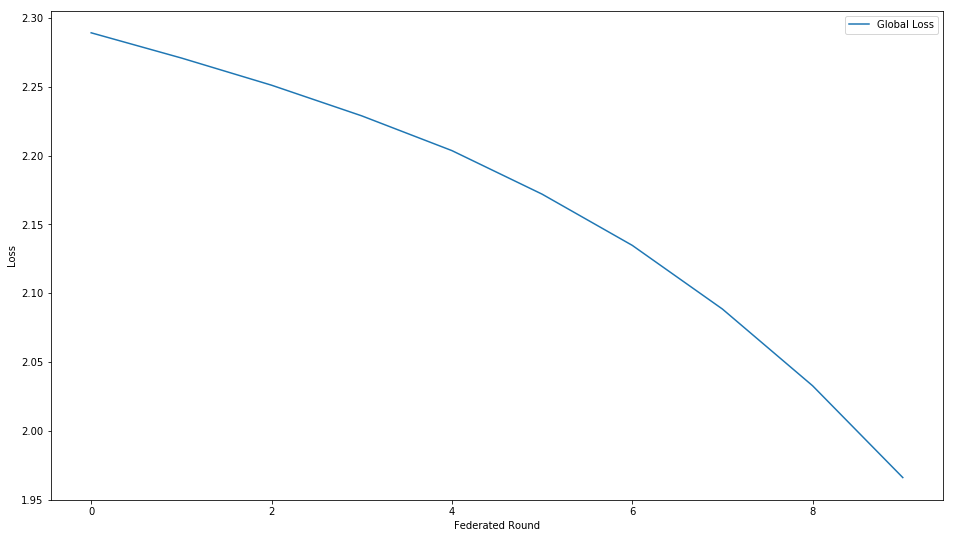

In [69]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 9))
# loss of global model on test set gets recorded twice per round
# [1::2] skips the record that takes place before that round's training has happened
ax.plot(manager.manager_loss_history[1::2], label="Global Loss", )
ax.set_xlabel("Federated Round")
ax.set_ylabel("Loss")
ax.legend();

This looks pretty good, with loss dropping off just like we want. Perhaps it's a little bumpy because of the relatively fast training rate, but it should be improving on balance. But if we look under the hood at each individual worker's loss, we see that the workers' local models are diverging and converging at each round. They diverge because each local model trains on different data, resulting in a somewhat different loss per round. The converge again because the manager combines them into a master model, such that they all have the same loss as the global loss.

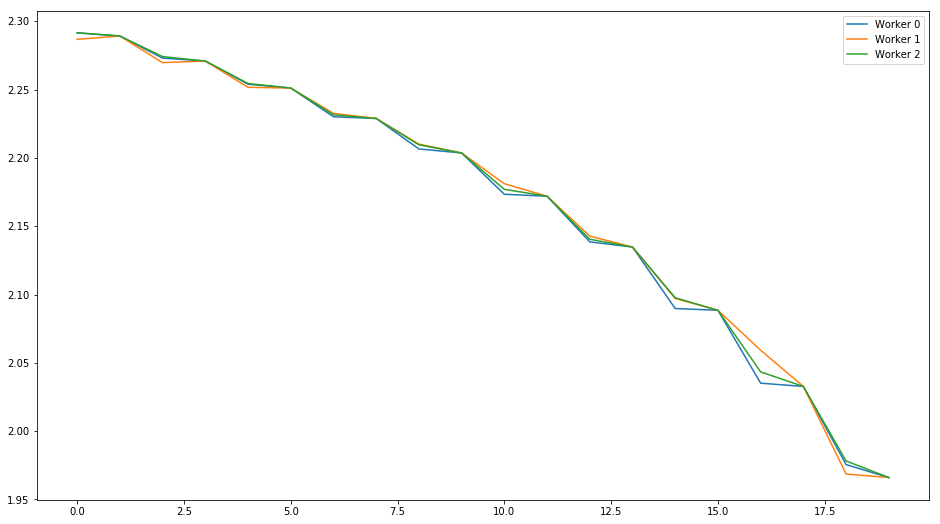

In [70]:
fig, ax = plt.subplots(figsize=(16, 9))

for i in range(len(manager.worker_loss_histories)):
    ax.plot(manager.worker_loss_histories[i], label=('Worker ' + str(i)))

ax.legend();

TODO: Write a bit of code that records the hyperparameters and saves the graphs, times and losses in a bundle for each run. Something like:

```
2019-05-06 21:02:50

# standard dataloader parameter
batch_size = 128

# biasing parameters
skew_bias = 0.3
loader_size = 8192
num_workers = 10

Stacked set creation time: 00:01:08

# training parameters
learning_rate = 1e-2
num_epochs = 1
num_rounds = 20

Train time = 00:43:02

Final global loss: 0.48251
```

Well. I did this. And now the code is unreadable.

Outline:
- Set up a model and data
- train the model N epochs without federation note baseline performance (and size of the data that would have to have been transferedd?) 
    - is this model trained on the full dataset? Or do we sample randomly across it to have the same number of examples?
- Federate without skew or mild skew, compare performance with baseline (and size of model compared to data)
- Federate with only a few numbers skewed (like, lacking only 7s or something) 
- Federate with heavy skew
- Federate with complete skew

Ideas:
- plot performance on a given numeral for the main model next to that of a worker skewed against that numeral. Let both run without federation or run a few epochs before federation. Show this as a baseline
- histogram of numerals? More for curiosity, but shows spread of data that we might want to reflect in the baseline training.
- post 1: what's the accuracy loss for federation compared to baseline direct training?
- post 2: weird side stats
    - skew vs. accuracy
        - plot - x-axis = skew, y-axis = accuracy
    - run all to convergence, compare how long to reach comparable accuracy?
        - time or epochs necessary to reach comparable accuracy between federated and standard approach
        - time or epochs necessary to reach comparable accuracy by skew
    - 

Questions:
- Why does the time spent by a worker on any given epoch all happen _before_ the batches start rolling in? What's happening there? Am I just spinning my wheels on something?
    - TODO: try this from a regular python file. The notebook may be buffering up those print statements in the batches
- Why does random selection of the skewed datasets take so long? Is it because they're without replacement?
- Why do all the workers and epochs always happen in order? Wouldn't my laptop parallelize them across cores? Is that too much to ask from an interpreter? Is the interpreter smarter than I am and actually is parallelizing them and the smartest way in to do them in order?
- why use ten workers? Why not fewer?

- TODO: unequal data volume at each worker. Try some workers with very small or very large samples.

In [71]:
# a little performance info on the run
run_data['Global End Time'] = time.time()
run_data['Global Time'] = run_data['Global End Time'] - run_data['Global Start Time']
run_data

{'Date': '2019-08-07 15:44:37',
 'Global Start Time': 1565207077.3375742,
 'Batch Size': 128,
 'Skew Bias': 0.5,
 'Examples Per Skewed Loader': 256,
 'Number of Workers': 3,
 'Stacking Time': 26.015615463256836,
 'Stacking Time per Loader': 8.671871821085611,
 'Learning Rate': 0.05,
 'Epochs per Round': 3,
 'Federated Training Rounds': 10,
 'Federated Training Time': 43.8322434425354,
 'Final Global Loss': 1.9660507440567017,
 'Global End Time': 1565220649.2201946,
 'Global Time': 13571.882620334625}

In [72]:
# leave a record of the run
# but it isn't valid JSON
import json 
with open('run_data.json', 'a') as file:
    file.write(json.dumps(run_data))
    file.write('\n\n')